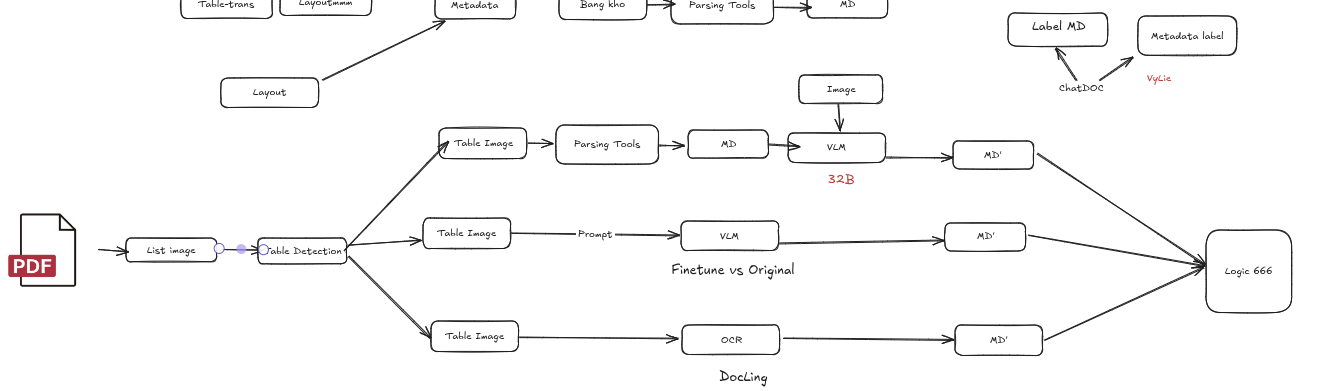

In [1]:
# !pip install pdf2image poppler pymupdf pillow
# !pip install paddlepaddle
# !pip install ppstructure

In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


c:\Users\Admin\Data\multimodal-rag-baseline


In [3]:
from configs.config import *
from libs.common import *
from utils.mongodb_connection import *
from utils.rag_utils import *
from utils.format_utils import *
load_dotenv(find_dotenv())

c:/Users/Admin/Data/multimodal-rag-baseline


c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


True

In [4]:
from utils.extract_table_img import detect_tables_and_save_images

In [5]:
from utils.extract_tables import full_pipeline

In [6]:
source_path=f'{data_dir}/pdf/test/0c92f65db928c431023f59603039aa1e.pdf'

In [7]:
# json_result = full_pipeline(source_path=source_path, verbose=1)
# print(json_result)
# filename = 'output.json'
# try:
#     with open(filename, 'w', encoding='utf-8') as f:
#         json.dump(json_result, f, ensure_ascii=False, indent=4)
#     print(f"Đã lưu dữ liệu vào file: {filename}")
# except Exception as e:
#     print(f"[LỖI] Không thể ghi file JSON: {e}")

In [8]:
import requests
import json

def summary_fn(prompt):
    """
    Gửi prompt đến Ollama và nhận về một đoạn phản hồi hoàn chỉnh.
    
    Tham số:
        prompt (str): Câu hỏi hoặc yêu cầu bạn muốn gửi đến mô hình.

    Trả về:
        str: Phản hồi hoàn chỉnh từ mô hình.
    """
    full_response = ""
    context = f"""
    You are given a single table fragment extracted from a PDF document using OCR. This fragment may be part of a larger table that was split across multiple pages due to formatting or page layout.
    Your task is to generate a detailed and comprehensive summary of the content in this table fragment.
    The summary should clearly describe:
        The main subject or topic of the table
        Key columns and their meanings
        Important patterns, trends, or observations in the data
        Any notable values or anomalies
        Contextual information needed to understand the data
    Write the summary in 1–3 full sentences , using clear and precise language.
    If applicable, mention that this fragment appears to be part of a larger table, and include any inferred continuity from the data.
    {prompt}
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": "gemma3:latest",
        "prompt": context,
        "stream": True
    }

    with requests.post(url, json=payload, stream=True) as response:
        for line in response.iter_lines():
            if line:
                try:
                    data = json.loads(line)
                    if 'response' in data:
                        chunk = data['response']
                        full_response += chunk
                    if data.get('done', False):
                        break
                except json.JSONDecodeError:
                    continue  

    return full_response.strip()

In [9]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    else:
        print("GPU is NOT available")

check_gpu()


GPU is available: NVIDIA GeForce RTX 4060 Laptop GPU


In [10]:
import requests

def list_models_by_provider_and_tag(providers, pipeline_tag):
    # providers là list hoặc str, pipeline_tag là str
    providers_str = ",".join(providers) if isinstance(providers, list) else providers
    url = f"https://huggingface.co/api/models?inference_provider={providers_str}&pipeline_tag={pipeline_tag}"
    response = requests.get(url)
    response.raise_for_status()
    models = response.json()
    return [model["id"] for model in models]

if __name__ == "__main__":
    providers = ["sambanova"]
    pipeline_tag = "feature-extraction"  # hoặc "text-generation", "image-classification", v.v.
    models = list_models_by_provider_and_tag(providers, pipeline_tag)
    print(f"Models with pipeline_tag={pipeline_tag} served by {providers}:")
    for m in models:
        print(" ", m)


Models with pipeline_tag=feature-extraction served by ['sambanova']:
  intfloat/e5-mistral-7b-instruct


In [38]:
TARGET_DIM = 1536  # hoặc 1024, 1536,... tùy nhu cầu

def pad_or_truncate(vec, target_dim=TARGET_DIM):
    current_dim = vec.shape[0]
    if current_dim > target_dim:
        return vec[:target_dim]
    elif current_dim < target_dim:
        padding = torch.zeros(target_dim - current_dim)
        return torch.cat([vec, padding])
    else:
        return vec

In [39]:
import torch
from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_id, torch_dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_id)

def get_image_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    
    # Prompt mặc định bắt buộc phải có
    prompt = "Describe this image."

    # Gọi processor để lấy tensor ảnh + grid thông tin
    inputs = processor(images=img, text=prompt, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)
    grid_thw = inputs["image_grid_thw"].to(device)

    # Di chuyển visual module lên GPU nếu chưa
    model.visual.to(device)

    with torch.no_grad():
        # Trích xuất embedding từ ảnh thông qua visual module
        vision_outputs = model.visual(pixel_values, grid_thw)
        image_emb = vision_outputs.mean(dim=1).squeeze(0).cpu()  # Mean pooling
        image_emb = pad_or_truncate(image_emb, TARGET_DIM)

    return image_emb

# Hàm lấy embedding cho văn bản
def get_text_embedding(text):
    inputs = processor(text=text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.model.language_model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        text_emb = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu()
        text_emb = pad_or_truncate(text_emb, TARGET_DIM)
    return text_emb




Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


In [40]:
tables_sources = json.load(open("output.json"))
sources = list(tables_sources.keys())

In [41]:
# vector_embbed = get_image_embedding('./table_snapshots/0c92f65db928c431023f59603039aa1e_page2_table1.png')
# print("Vector embedding shape:", vector_embbed.shape)
# table = tables_sources[sources[0]]
# text_embbed = get_text_embedding(table['table_content'])
# print("Text embedding shape:", text_embbed.shape)

In [42]:
image_dir = "./table_snapshots"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")]

image_embeddings = {
    path: get_image_embedding(path)
    for path in image_paths
}


In [43]:
image_embeddings

{'./table_snapshots\\0c92f65db928c431023f59603039aa1e_page10_table1.png': tensor([0.0041, 0.0505, 0.0243,  ..., 0.0075, 0.0182, 0.0200],
        dtype=torch.bfloat16),
 './table_snapshots\\0c92f65db928c431023f59603039aa1e_page12_table1.png': tensor([-0.0020,  0.0508,  0.0036,  ...,  0.0289,  0.0405,  0.0347],
        dtype=torch.bfloat16),
 './table_snapshots\\0c92f65db928c431023f59603039aa1e_page13_table1.png': tensor([ 0.0064,  0.0271,  0.0131,  ...,  0.0017, -0.0009,  0.0276],
        dtype=torch.bfloat16),
 './table_snapshots\\0c92f65db928c431023f59603039aa1e_page14_table1.png': tensor([ 0.0029,  0.0515,  0.0118,  ..., -0.0217, -0.0183, -0.0205],
        dtype=torch.bfloat16),
 './table_snapshots\\0c92f65db928c431023f59603039aa1e_page15_table1.png': tensor([0.0024, 0.0430, 0.0164,  ..., 0.0308, 0.0283, 0.0118],
        dtype=torch.bfloat16),
 './table_snapshots\\0c92f65db928c431023f59603039aa1e_page16_table1.png': tensor([ 0.0145, -0.0056, -0.0105,  ...,  0.0250,  0.0260,  0.0121],

In [44]:
for path, embedding in image_embeddings.items():
    print(f"{path}: {embedding.shape}")


./table_snapshots\0c92f65db928c431023f59603039aa1e_page10_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page12_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page13_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page14_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page15_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page16_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page17_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page18_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page18_table2.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page19_table1.png: torch.Size([1536])
./table_snapshots\0c92f65db928c431023f59603039aa1e_page20_table1.png: torch.Size([1536])
./table_snapshots\0c9

In [45]:
from torch.nn.functional import cosine_similarity


# Lặp qua từng bảng trong từng source
for source in sources:
    print(f"source {source} has {len(tables_sources[source])} tables")
    print("-" * 100)
    
    for table_idx, table in enumerate(tables_sources[source]):
        # Lấy nội dung bảng và tóm tắt
        table_text = table['table_content']
        table_vec = get_text_embedding(table_text)

        # Tính cosine similarity giữa văn bản bảng và từng ảnh
        similarities = {
            path: cosine_similarity(table_vec.unsqueeze(0), image_vec.unsqueeze(0)).item()
            for path, image_vec in image_embeddings.items()
        }

        print(similarities)

        # Lấy top-3 ảnh phù hợp nhất
        best_images = {
            path: score
            for path, score in similarities.items()
            if score > 0.65
        }
        table['matched_images'] = [img_path for img_path, sim in best_images]

source 0c92f65db928c431023f59603039aa1e has 15 tables
----------------------------------------------------------------------------------------------------
{'./table_snapshots\\0c92f65db928c431023f59603039aa1e_page10_table1.png': 0.00360107421875, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page12_table1.png': -0.002410888671875, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page13_table1.png': 0.007720947265625, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page14_table1.png': 0.002716064453125, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page15_table1.png': -0.011474609375, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page16_table1.png': 0.01025390625, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page17_table1.png': -0.0213623046875, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page18_table1.png': 0.008363652043044567, './table_snapshots\\0c92f65db928c431023f59603039aa1e_page18_table2.png': 0.0277099609375, './table_snapshots\\0c

In [60]:
tables_sources = json.load(open(f"./test.json"))
sources = list(tables_sources.keys())
for source in sources:
    print(f"source {source} has {len(tables_sources[source])} tables")
    print("-" * 100)
    for table in tables_sources[source]:
        table_md = table['table_content']
        table_idx = table['table_idx']
        source_name = table['source']
        matched_images = table.get("matched_images", [])

        images_md = "\n".join([f"![Table image]({os.path.basename(img)})" for img in matched_images])
        filename = f"{source_name.replace('.pdf','')}_table_{table_idx}.md"
        filepath = f"./mds/{filename}"

        markdown_content = f"""---
    source_pdf: {table['source']}
    table_idx: {table_idx}
    matched_images:
    {chr(10).join([f"  - {os.path.basename(img)}" for img in matched_images])}
    ---

    {images_md}

    {table_md}
    """

        with open(filepath, "w", encoding="utf-8") as f:
            f.write(markdown_content)

        print(f"✅ Saved: {filepath}")

source ccc3348504535e22aa44231e57052869 has 24 tables
----------------------------------------------------------------------------------------------------
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_0.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_1.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_2.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_3.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_4.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_5.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_6.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_7.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_8.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_9.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_10.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_11.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_12.md
✅ Saved: ./mds/ccc3348504535e22aa44231e57052869_table_13.md
✅ Saved: ./mds/

dung o day

In [ ]:
# import json

# tables_sources = json.load(open("output.json"))
# sources = list(tables_sources.keys())

# for source in sources:
#     print(f"source {source} has {len(tables_sources[source])} tables")
#     print("-" * 100)

#     # Loop through each table in the source
#     for table in tables_sources[source]:
#         table_md = table['table_content']
#         page_numbers = table['page_numbers']
#         source_name = table['source']
#         table_idx = table['table_idx']
#         table_summary = summary_fn(table_md)
#         # image_files = table_idx_map.get(table_idx, [])  # danh sách ảnh cho bảng này

#         images_md = "\n".join([f"![Table image](images/{img})" for img in image_files])

#         print(table['table_content'])
#         print("-" * 100)

#         # Generate unique filename for each table
#         filename = f"{source_name.replace('.pdf','')}_table_{table_idx}.md"
#         filepath = f"./md/{filename}"  # use a folder like ./outputs/

#         markdown_content = f"""---
# source_pdf: {source_name}
# table_idx: {table_idx}
# page_numbers: {page_numbers}
# summary: {table_summary}
# images:
# # {chr(10).join([f"  - images/{img}" for img in image_files])}
# ---

# ![Table image](images/{source_name.replace('.pdf','')}_page{page_numbers}_table{table_idx}.png)

# {table_md}
# """

#         with open(filepath, "w", encoding="utf-8") as f:
#             f.write(markdown_content)

#         print(f"✅ Saved: {filepath}")


source 0c92f65db928c431023f59603039aa1e has 15 tables
----------------------------------------------------------------------------------------------------
# 0c92f65db928c431023f59603039aa1e_table_0
## Associated Context(s) Before Table:
- eligibility became the full previous calendar year from January 1 to December 31.[5] Table key

This is a single-page table. Page number: 2

| 0   | 1                              |
|:----|:-------------------------------|
|     | Table key                      |
| ‡   | Indicates the winner           |
| †   | Indicates a posthumous nominee |

Shape: (3, 2)

----------------------------------------------------------------------------------------------------
✅ Saved: ./0c92f65db928c431023f59603039aa1e_table_0.md
# 0c92f65db928c431023f59603039aa1e_table_1
## Associated Context(s) Before Table:
- Street Angel (1928), and Sunrise: A Song of Two Humans (1927). 1920s ​[ edit ]

This is a single-page table. Page number: 2

| 0        | 1                | 2 

In [6]:
detect_tables_and_save_images(source_path)


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warni

✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page2_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page3_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page4_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page5_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page5_table2.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page6_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page7_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page7_table2.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page8_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page9_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page9_table2.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page10_table1.png
✅ Saved: table_snapshots\0c92f65db928c431023f59603039aa1e_page12_table1.png
✅ Saved: table_snapshot

In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/llava-instruct-mix-vsft-mini", split = "train")

In [ ]:
dataset

In [ ]:
dataset[2]["images"][0]

In [ ]:
dataset[2]["messages"]

In [ ]:
image = Image.open("path/to/table_image.png").convert("RGB")

### VLM-LLM Base Enrich approach

In [47]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image
import torch

In [53]:
path = './ccc3348504535e22aa44231e57052869.pdf'
json_result = full_pipeline(source_path=path, verbose=1)
print(json_result)
filename ='test.json'
try:
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(json_result, f, ensure_ascii=False, indent=4)
    print(f"Đã lưu dữ liệu vào file: {filename}")
except Exception as e:
    print(f"[LỖI] Không thể ghi file JSON: {e}")

Processing file: ccc3348504535e22aa44231e57052869...
File: ccc3348504535e22aa44231e57052869, Input tokens: 14918, Output tokens: 549
Model: gemini-2.0-flash-001, Total input tokens: 14918, Total output tokens: 549
Time taken: 13.552 seconds
{'ccc3348504535e22aa44231e57052869': [{'table_content': "# ccc3348504535e22aa44231e57052869_table_0\n## Associated Context(s) Before Table:\n- streak indicates that the streak is also the team's longest-ever streak for consecutive playoff seasons.\n\nCross-page table spanning pages: [1, 2]\n| 0                                       | 1                                  | 2    | 3    | 4    | 5                                 | 6                                    | 7                   | 8                | 9                   | 10          | 11   |\n|:----------------------------------------|:-----------------------------------|:-----|:-----|:-----|:----------------------------------|:-------------------------------------|:--------------------|:------

In [54]:
tables_sources = json.load(open(f"./test.json"))
sources = list(tables_sources.keys())
print(f"Tổng cộng có {len(sources)} nguồn tài liệu:")
for source in sources:
    print(f"source {source} has {len(tables_sources[source])} tables")
    print("-" * 100)
    # Loop through each table in the source
    for table in tables_sources[source]:
        
        ## Mỗi 1 table có các keys là ['table_content', 'page_numbers', 'source', 'table_idx']
        ## Trong đó table_content là markdown của bảng
        ## page_numbers là list các page number mà bảng xuất hiện
        ## source là tên của pdf
        ## table_idx là index của bảng trong pdf
        print(table['table_content'])
        print("-" * 100)

Tổng cộng có 1 nguồn tài liệu:
source ccc3348504535e22aa44231e57052869 has 24 tables
----------------------------------------------------------------------------------------------------
# ccc3348504535e22aa44231e57052869_table_0
## Associated Context(s) Before Table:
- streak indicates that the streak is also the team's longest-ever streak for consecutive playoff seasons.

Cross-page table spanning pages: [1, 2]
| 0                                       | 1                                  | 2    | 3    | 4    | 5                                 | 6                                    | 7                   | 8                | 9                   | 10          | 11   |
|:----------------------------------------|:-----------------------------------|:-----|:-----|:-----|:----------------------------------|:-------------------------------------|:--------------------|:-----------------|:--------------------|:------------|:-----|
| Current consecutive Playoff appearances |                   

In [59]:
tables_sources[sources[0]][0]

{'table_content': "# ccc3348504535e22aa44231e57052869_table_0\n## Associated Context(s) Before Table:\n- streak indicates that the streak is also the team's longest-ever streak for consecutive playoff seasons.\n\nCross-page table spanning pages: [1, 2]\n| 0                                       | 1                                  | 2    | 3    | 4    | 5                                 | 6                                    | 7                   | 8                | 9                   | 10          | 11   |\n|:----------------------------------------|:-----------------------------------|:-----|:-----|:-----|:----------------------------------|:-------------------------------------|:--------------------|:-----------------|:--------------------|:------------|:-----|\n| Current consecutive Playoff appearances |                                    |      |      |      |                                   |                                      |                     |                  |     

In [55]:
print(tables_sources.keys())

dict_keys(['ccc3348504535e22aa44231e57052869'])


In [ ]:
table

In [51]:
from utils.extract_table_img import detect_tables_and_save_images
detect_tables_and_save_images(path, output_dir='./img_test')


c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Admin\miniconda3\envs\kyanon_digital\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a met

✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page1_table0_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page2_table1_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page2_table1_part2.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page2_table1_part3.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page3_table2_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page3_table2_part2.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page4_table3_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page5_table4_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page6_table5_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page7_table6_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page8_table7_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page9_table8_part1.png
✅ Saved: ./img_test\ccc3348504535e22aa44231e57052869_page10_table9_part1.png
✅ Saved: ./

#### Cross-page table

In [61]:
markdown_file_path = "mds/ccc3348504535e22aa44231e57052869_table_0.md"

with open(markdown_file_path, "r", encoding="utf-8") as f:
    markdown_content = f.read()

markdown_prompt = f"""
Based on all the provided table images, please verify, complete, and correct the Markdown table below to accurately reflect the content in the images.

Only return the corrected Markdown table. Do not include any explanations or additional text.
{markdown_content}
"""




In [ ]:
markdown_prompt

"\nBased on all the provided table images, please verify, complete, and correct the Markdown table below to accurately reflect the content in the images.\n\nOnly return the corrected Markdown table. Do not include any explanations or additional text.\n---\n    source_pdf: ccc3348504535e22aa44231e57052869\n    table_idx: 0\n    matched_images:\n    \n    ---\n\n    \n\n    # ccc3348504535e22aa44231e57052869_table_0\n## Associated Context(s) Before Table:\n- streak indicates that the streak is also the team's longest-ever streak for consecutive playoff seasons.\n\nCross-page table spanning pages: [1, 2]\n| 0                                       | 1                                  | 2    | 3    | 4    | 5                                 | 6                                    | 7                   | 8                | 9                   | 10          | 11   |\n|:----------------------------------------|:-----------------------------------|:-----|:-----|:-----|:--------------------------

In [ ]:
# markdown_prompt = """
# ### Table ID: source_pdf_1
# ![Table image](../tables/source_pdf_1.png)
# **Metadata**
# - Page: 3
# - Source: report_abc.pdf
# """

In [68]:
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base").to(device)
processor = AutoProcessor.from_pretrained("google/pix2struct-base")

In [69]:
img1 = Image.open("img_test/ccc3348504535e22aa44231e57052869_page1_table0_part1.png").convert("RGB")
# img2 = Image.open("path/to/image2.png").convert("RGB")
# img3 = Image.open("path/to/image3.png").convert("RGB")

In [70]:
inputs = processor(images=[img1], text=markdown_prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
outputs = model.generate(**inputs, max_new_tokens=3096)
generated_text = processor.decode(outputs[0], skip_special_tokens=True)

print("\n📦 Markdown Output:\n", generated_text)

### Span table

### Openroute

#### Summarize

In [ ]:


credentials_path = "C:/Users/Admin/Data/multimodal-rag-baseline/gdsc2025-74596a254ab4.json"

credentials = service_account.Credentials.from_service_account_file(credentials_path)


In [ ]:
import base64

# Bước 1: Đọc ảnh và encode base64
image_path = "img_test/ccc3348504535e22aa44231e57052869_page1_table0_part1.png"  # Thay đường dẫn ảnh ở đây
with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
import requests
import json

response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {os.getenv('API_OPENROUTE')}",
    "Content-Type": "application/json",
  },
  data=json.dumps({
    "model": "qwen/qwen2.5-vl-32b-instruct:free",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": """
This image contains a data table or a keyboard shortcut matrix.
Please analyze and describe it thoroughly based on the following instructions:

Table Structure:

How many rows and columns are there?

What are the headers of each column?

Is there a total row, footer, or any notes?

Data Overview:

List the data row by row if possible.

Explain the meaning of each value in the table cells.

Clarify any special symbols (e.g., %, $, color codes, icons).

In-depth Analysis:

Which rows or columns stand out as significant?

Are there any relationships, patterns, or correlations between columns?

Identify any upward/downward trends.

Point out any anomalies or outliers in the data.

Comparison and Interpretation:

Compare values across rows or groups.

Identify the highest and lowest values.

What does the table suggest or imply overall?

If the table contains keyboard shortcuts or commands:

Describe the action associated with each shortcut key combination.

Group the shortcuts by functionality if possible (e.g., navigation, editing, system-level commands).

Please present your response in a well-structured and easy-to-read format. Use bullet points or numbered lists where appropriate."""
          },
          {
            "type": "image_url",
            "image_url": {
              "url": "data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    
  })
)

In [ ]:
import requests
import json

response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {os.getenv('API_OPENROUTE')}", # Replace with your OpenRouter API key
    "Content-Type": "application/json",
  },
  data=json.dumps({
    "model": "mistralai/mistral-small-3.1-24b-instruct:free",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "What is in this image?"
          },
           {
            "type": "image_url",
            "image_url": {
              "url": "data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    
  })
)

VLM-LLM Finetuning Enrich Approach

#### PEFT - LoRA

In [ ]:
from transformers import Pix2StructForConditionalGeneration, AutoProcessor, TrainingArguments, Trainer
from datasets import load_dataset, load_image
from peft import get_peft_model, LoraConfig, TaskType
import torch

In [ ]:
model_id = "google/pix2struct-pixtral-base"
processor = AutoProcessor.from_pretrained(model_id)
model = Pix2StructForConditionalGeneration.from_pretrained(model_id)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, peft_config)

In [ ]:
def preprocess(example):
    image = load_image(example["image"])
    encoding = processor(images=image, text=example["text_input"], return_tensors="pt", truncation=True)
    encoding["labels"] = processor.tokenizer(example["text_output"], return_tensors="pt").input_ids[0]
    return encoding

dataset = dataset.map(preprocess)

In [ ]:
training_args = TrainingArguments(
    output_dir="./pixtral-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=5,
    fp16=True,
    evaluation_strategy="no",
    save_strategy="epoch",
    logging_steps=10,
    save_total_limit=2
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    tokenizer=processor.tokenizer
)

trainer.train()

#### Unsloth

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    # We do NOT finetune vision & attention layers since Pixtral uses more memory!
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True,  # False if not finetuning language layers
    finetune_attention_modules = False, # False if not finetuning attention layers
    finetune_mlp_modules       = True,  # False if not finetuning MLP layers

    r = 8,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1, # Reduce to 1 to make Pixtral fit!
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
trainer_stats = trainer.train()

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = "Is there something interesting about this image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["images"][0]
instruction = "What colors are in the image?"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64,
                   use_cache = True, temperature = 1.5, min_p = 0.1)